In [1]:
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

In [2]:
'''
Some code for frequency estimation
'''

class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences
        
def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

def TE_mode_sort(mode_num=1):
    '''
    This calculates allowable nml values for the TE modes of the resonator. Uses above functions
    '''
    
    permutes=[[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[2,0,2],[2,0,3],[2,0,4],[2,0,5],[3,0,3],[3,0,4],[3,0,5]]
    nml=[]
    for i in range(len(permutes)):
        perms=np.array(list(perm_unique(permutes[i])))
        for vals in perms:
            if vals[0]!=0 and vals[1]==0 and vals[2]!=0:
                nml.append(list(vals))
            else:
                pass
    nml=np.array(nml)
    i_sort=np.argsort(nml[:,0])
    return nml[i_sort][0:mode_num]


def freq_rect(a,b,c, modes=1, unit='metric'):
    '''
    Calculate the lowest n-mode frequencies for a rectangular cavity of a,b,c dimensions where b is the smallest dim
    '''
    if unit=='metric':
        a=a/1000.
        b=b/1000.
        c=c/1000.
    elif unit=='imperial':
        a=a*.0254
        b=b*.0254
        c=c*.0254
    else:
        raise Exception('ERROR: Unit must be metric or imperial')
    
    eps=const.epsilon_0
    mu=const.mu_0
    c_speed=const.c
    nml_array=TE_mode_sort(10)
    f=[]

    for vals in nml_array:
        n=vals[0]
        m=vals[1]
        l=vals[2]
        f.append(((c_speed)/(2*pi))*sqrt((n*pi/a)**2+(m*pi/b)**2+(l*pi/c)**2))
    f=np.array(f)
    f_sort=np.argsort(f)
    return f[f_sort][0:modes], nml_array[f_sort]

def get_c_dim(f,a,b, unit='metric'):
    '''
    Estimates the second long dimension based on a target frequency and the other two dimensions. Works only for the 
    fundamental mode
    '''
    brentq=scipy.optimize.brentq
    f_intercept=lambda c:freq_rect(a,b,c,1, unit)[0][0]-f
    c=brentq(f_intercept, min([10*a, b]), max([10*a, b]))

    return c

def round_dim(dim, frac):
    val=frac*math.ceil(dim/frac)+frac
    if (val-dim)/2<frac:
        val=val+.25
    else:
        pass
    return val

def check_path(path):
    check=glob.glob(path)
    if check==[]:
        return False
    else:
        return True

def cap_sigma(cmat, units='fF'):
    cmat=Q(cmat, units).to('F').magnitude
    c11=abs(cmat[0,0])-abs(cmat[0,1])
    c22=abs(cmat[1,1])-abs(cmat[1,0])
    c12=abs(cmat[0,1])/2+abs(cmat[1,0])/2
    return (c12+(c11*c22)/(c11+c22))

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    print (csig)
    return const.e**2/(2*(csig))/const.h

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    return const.e**2/(2*(csig))/const.h

def Ec_to_C(Ec):
    Ec = Ec*const.h
    return const.e**2/(2*Ec)

def L_from_nu_and_C(nu,C):
    return (1/nu**2/4/np.pi**2/C)

# PyInventor and cavity design:
The following shows a basic example of how to setup and compile an Inventor design using the PyInventor designs. To learn more about PyInventor and see various examples of how PyInventor can be used for cavity design please refer to: https://github.com/AndrewOriani/PyInventor and the tutorial and demo notebooks contained within.


In [3]:
def single_pan_pipe(target_freq, hole_spacing=0.2375,
                   hole_dia=0.1875, H_stock=2.25,
                    evan_length=0.5,
                   units='imperial',
                   fname='single_pan_pipe.ipt'):
    """
    Creates a single mode pan-pipe cavity with inventor
    """
    # Start at the origin
    stock_origin=(0,0)

    #calculate cavity height allowed by stock
    H_cav=H_stock-2*evan_length

    #calculate what you want the length of t he cavity to be for  the proper fundamental frequency
    L_cav=get_c_dim(target_freq, H_cav, hole_dia, units)

    #set the maximum number of holes, call them top
    num_holes_top=round((L_cav-hole_dia)/hole_spacing)+1

    #number of bottom holes
    num_holes_bot=num_holes_top-1

    #recalculate frequency now that holes are set
    eff_cav_L=(num_holes_top-1)*hole_spacing+hole_dia
    H_cav=get_c_dim(target_freq, eff_cav_L, hole_dia, units)

    # calculate stock length for the given cavity length needed
    # rounds length to nearest designated fraction
    L_stock=round_dim(L_cav, .25)
    W_stock=round_dim(hole_dia, .125)

    #start inventor and close all inventor objects
    com_obj().close_all_parts()

    #set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
    overwrite=True

    # path='Z:\\Andrew Oriani\\CQED 3D Resonators\\Multimode Manipulate Cavity\\3D MM V3'

    #for demo set the path to path='' to save in current working directory
    path=os.getcwd() + '\\Inventor Files\\'

    #setup part 
    part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

    #set view as shaded with edges
    part.set_visual_style(shaded=True, edges=True, hidden_edges=True)

    #set starting workplane
    lower_wp=part.add_workplane(plane='xy')

    #attach a sketch to the workplane
    sketch_1=part.new_sketch(lower_wp)

    #set upper workplane
    upper_wp=part.add_workplane(plane='xy', offset=H_stock)

    #attach a sketch to the upper workplane
    sketch_2=part.new_sketch(upper_wp)

    #create stock base associated with sketch 1. The structuire object keeps track of position
    stock_base=structure(part, sketch_1, start=stock_origin)

    stock_base.add_line(L_stock, 180)
    stock_base.add_line(W_stock, 90)
    stock_base.add_line(L_stock, 0)
    stock_base.add_line(W_stock, 270)

    #structure identifier
    base_shape=stock_base.draw_path(close_path=True)

    #extrude base shape. It is important to set the object collection (obj_collection) to the specific polygon shape we created
    base_extrusion=part.extrude(sketch_1, thickness=H_stock, obj_collection=base_shape, direction='positive', operation='join')

    #fits whole cavity in frame
    part.view.Fit()

    #hole starting coordinate
    hole_start=(-(L_stock-L_cav+hole_dia)/2, W_stock/2)

    #structure identifier
    cav_holes_top=structure(part, sketch_1, start=hole_start)
    cav_holes_bot=structure(part, sketch_2, start=(hole_start[0]-hole_spacing/2, hole_start[1]))

    #set total hole distance for top holes
    hole_dist_top=hole_spacing*(num_holes_top-1)
    hole_dist_bot=hole_spacing*(num_holes_bot-1)

    #start drawing points for top holes
    cav_holes_top.add_point_line(distance=hole_dist_top , direction=180, num_points=num_holes_top)   
    top_holes_pos=cav_holes_top.get_pts()[0]

    #create top holes by just putting in the list of positions. It will automatically make an object collection
    hole_depth=H_cav+evan_length
    part.new_hole(sketch=sketch_1, pos=top_holes_pos, dia=hole_dia, depth=hole_depth, direction='negative', FlatBottom=False, BottomTipAngle=None)

    #start drawing holes for bottom points
    cav_holes_bot.add_point_line(distance=hole_dist_bot , direction=180, num_points=num_holes_bot)   
    bot_holes_pos=cav_holes_bot.get_pts()[0]

    #create bottom holes
    part.new_hole(sketch=sketch_2, pos=bot_holes_pos, dia=hole_dia, depth=hole_depth, direction='positive', FlatBottom=False, BottomTipAngle=None)

    part.view.GoHome()

    #Save document 
    part.save()

    #save copy as stp file for export to HFSS
    path=part.save_copy_as(copy_name=fname.split('.')[0]+'.stp' );

    print('Estimated TE_101 mode frequency: %.3e'%target_freq)
    
    return L_stock, W_stock, H_stock, bot_holes_pos, top_holes_pos

In [4]:
# Two calls to pan-pipe design
L_stock, W_stock, H_stock, bot_holes_pos, top_holes_pos \
= single_pan_pipe(target_freq=6.375e9, fname='flute_cavity_6p375_GHz.ipt')
L_stock2, W_stock2, H_stock2, bot_holes_pos2, top_holes_pos2 \
= single_pan_pipe(target_freq=7.375e9, fname='flute_cavity_7p375_GHz.ipt')

Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
File successfully copied as: Z:\tcav\ipynbs\Inventor Files\\00009_flute_cavity_6p375_GHz.stp
Estimated TE_101 mode frequency: 6.375e+09
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
Attempting to open Inventor with GetActiveObject ...
Attempting to open Inventor with Dispatch ...
File successfully copied as: Z:\tcav\ipynbs\Inventor Files\\00003_flute_cavity_7p375_GHz.stp
Estimated TE_101 mode frequency: 7.375e+09


# Eigenmode:

<img src="Pictures/Cavity Eigenmode.png" alt="drawing" width="400">

Determines first 5 eigenmode frequencies in absence of any qubit. This demonstration also calculates S_e and S_m (electric and magnetic field participation of the cavity modes) for the first (TE_101) mode.

In [4]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
path = 'Z:\\tcav\\ipynbs\\Inventor Files\\'
project_name='post_coupler'
design_name='post_test'



stp_exists = glob.glob(path+'flute_cavity_6p375_GHz.stp')
print(f'flute_cavity_6p375_GHz.stp exists: {stp_exists}')
stp_exists = glob.glob(path+'flute_cavity_7p375_GHz.stp')
print(f'flute_cavity_7p475_GHz.stp exists: {stp_exists}')

# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
# solution_type = 'eigenmode'

solution_type = 'driven_modal'
overwrite=True
ref_name = 'post_cavity_l_coupled_three_cavities_degen_eigen'
# ref_name = 'planar_pads_l_coupled_three_cavities_degen'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'


#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_em_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

flute_cavity_6p375_GHz.stp exists: ['Z:\\tcav\\ipynbs\\Inventor Files\\flute_cavity_6p375_GHz.stp']
flute_cavity_7p475_GHz.stp exists: ['Z:\\tcav\\ipynbs\\Inventor Files\\flute_cavity_7p375_GHz.stp']
project_name: post_cavity_l_coupled_three_cavities_degen_eigen_230131
path: Z:\tcav\ipynbs\HFSS\post_cavity_l_coupled_three_cavities_degen_eigen_230131.aedt


C:\Users\nmaterise\.conda\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: post_cavity_l_coupled_three_cavities_degen_eigen_230131.aedt
C:\Users\nmaterise\.conda\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


project_name: post_cavity_l_coupled_three_cavities_degen_eigen_230131
path: Z:\tcav\ipynbs\HFSS\post_cavity_l_coupled_three_cavities_degen_eigen_230131.aedt


In [ ]:
# Stock subtraction for cavity 1
model.import_3D_obj(path+'flute_cavity_6p375_GHz.stp')
Stock_L=EM_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
Stock_W=EM_design.set_variable('Stock_W', '%.3fin'%(W_stock))
Stock_H=EM_design.set_variable('Stock_H', '%.3fin'%(H_stock))

cav_dims=[Stock_L, Stock_W, Stock_H]

box=model.draw_box_corner([0,0,0], cav_dims, name='cavity1')
objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

# Stock subtraction for cavity 2
# model.import_3D_obj(path+'flute_cavity_6p575_GHz.stp')
model.import_3D_obj(path+'flute_cavity_7p375_GHz.stp')
Stock_L2=EM_design.set_variable('Stock_L2', '%.3fin'%(-L_stock2))
Stock_W2=EM_design.set_variable('Stock_W2', '%.3fin'%(W_stock2))
Stock_H2=EM_design.set_variable('Stock_H2', '%.3fin'%(H_stock2))

cav_dims2=[Stock_L2, Stock_W2, Stock_H2]

box2=model.draw_box_corner([0,0,0], cav_dims2, name='cavity2')
obj_name2=model.subtract(blank_name='cavity2', tool_names=['Solid1_1'])

# Cavity 1 impedance boundary conditions
bot_hole_fid=[]
for locs in bot_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    top_hole_fid.append(fid)

top_imped=model.assign_impedance(377, 0, obj_name, 
                                 top_hole_fid, name='Top_Imped')
bot_imped=model.assign_impedance(377, 0, obj_name,
                                 bot_hole_fid, name='Bot_Imped')

# Cavity 2 impedance boundary conditions
bot_hole_fid=[]
for locs in bot_holes_pos2:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name2, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos2:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name2, pos=loc)
    top_hole_fid.append(fid)

top_imped=model.assign_impedance(377, 0, obj_name, 
                                 top_hole_fid, name='Top_Imped2')
bot_imped=model.assign_impedance(377, 0, obj_name,
                                 bot_hole_fid, name='Bot_Imped2')

# Move cavity #2 along a vector
intomm = 25.4
x_offset_mm = 10.
xoffset = EM_design.set_variable('x_offset', f'{x_offset_mm:.3f}mm')
xcorr = EM_design.set_variable('xoff_corr', '7.904534763mm')
xchip_start = EM_design.set_variable('xchip_start', '42.82948mm')
vec = [-(xoffset-xcorr)-xchip_start, #+offset_correction,
       0, 0]
obj2_name = model.translate('cavity2', vec)

# Chip setup
cpl_width = EM_design.set_variable('cpl_width', f'{2.2:.3f}mm')
l_chip = EM_design.set_variable('l_chip', '20mm')
h_chip = EM_design.set_variable('h_chip', '5mm')
t_chip = EM_design.set_variable('t_chip', '450um')
chip_dims = [t_chip, l_chip+cpl_width, h_chip]

# XXX: This is hard-coded, calculate this later
xchip_start = EM_design.set_variable('xchip_start', '42.82948mm')
chip_loc = [-xchip_start - xoffset/2,
            Stock_W/2 + l_chip / 2,
            Stock_H/2]

# Edit sapphire material properties
params = {'dielectric_loss_tangent' : 2e-8}
project.edit_material(params, 'sapphire')
chip = model.draw_box_center(chip_loc, chip_dims,
                            material='sapphire', name='chip')

# Coupler cavity setup
cpl_loc = [-xoffset/2 - xchip_start,
            Stock_W/2,
            Stock_H/2]
cpl_dims = [1.5*xoffset, cpl_width, Stock_H/4]
coupler = model.draw_box_center(cpl_loc, cpl_dims, name='coupler')

# Subtractions and unions
cavity_cpl = model.unite([obj_name, obj_name2, coupler])
cavity_cpl = model.subtract(cavity_cpl, [chip], keep_originals=True)

## Pad & junction positions

In [7]:
# Junction and pads
# Planar pads
l_junc = EM_design.set_variable('l_junc', '50um')
w_junc = EM_design.set_variable('w_junc', '10um')
pad_w = 10 * w_junc
pad_dims = [cpl_dims[1]/2 - l_junc/2, pad_w]

pad1_loc = [-xchip_start - xoffset/2 - t_chip/2,
            Stock_W/2 - pad_dims[0]/2 - l_junc/2,
            Stock_H/2]
pad2_loc = [-xchip_start - xoffset/2 - t_chip/2,
            Stock_W/2 + pad_dims[0]/2 + l_junc/2,
            Stock_H/2]

# Pad geometry
pad1 = model.draw_rect_center(pos=pad1_loc, x_size=0,
                          y_size=pad_dims[0],
                          z_size = pad_dims[1],
                          name='pad1')
pad2 = model.draw_rect_center(pos=pad2_loc, x_size=0,
                          y_size=pad_dims[0],
                          z_size = pad_dims[1],
                          name='pad2')

# Pad PEC assignment
model.assign_perfect_E([pad1, pad2], name='junction_pads')

In [8]:
# Junction geometry, eigenmode
if solution_type == 'eigenmode':
    junc_loc = [-xchip_start - xoffset/2 - t_chip/2,
                Stock_W/2,
                Stock_H/2]
    jj=model.draw_rect_center(pos=junc_loc, x_size=0,
                              y_size=l_junc,
                              z_size = w_junc, name='jj')

    # Junction inductance assignment
    Lj_val = 0.1
    L_jj=EM_design.set_variable('Lj_1', '%.3fnH' % Lj_val)
    jj_line=model.draw_polyline(jj.make_center_line(axis='Y'), 
                                    closed=False, name='jj_line')
    jj.make_rlc_boundary(l=L_jj, name='JJ_LJ', axis='Y')

In [9]:
EM_setup=EM_design.create_em_setup(name='Test_EM', 
                                   min_freq_ghz=2, 
                                   n_modes=8, 
                                   max_delta_f=1.0, 
                                   min_converged=1, 
                                   converge_on_real=True)

# time.sleep(5)

In [21]:
#setup the analysis and optimetrics
opti_setup = HFSS.Optimetrics(EM_design)

#set the optimetrics step size and number of steps
step = .2
num_step = 1

sweep_type = 'linear'

#create optimetrics setup
# swp_var = L_jj
# swp_var_unit = 'nH'
swp_var = xoffset
swp_var_unit = 'mm'
start = 1
stop = 15
dstep = 2
num_step = int(np.round((stop-start)/dstep) + 1)

tstamp = datetime.datetime.today().strftime('%y%m%d_%H_%M_%S')
if sweep_type == 'decade':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'decade',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    str(num_step)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
elif sweep_type == 'linear':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'linear_step',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    '%.2f%s' \
                                    % (((stop - start) / num_step),
                                       swp_var_unit)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
else:
    raise ValueError(f'sweep_type ({sweep_type}) unrecognized.')
            
#solve it
opti_setup.solve_setup(f'{swp_var}_Sweep_{tstamp}')

#save project
project.save()

Inserting optimetrics setup `x_offset_Sweep_230110_16_28_00` for simulation setup: `Test_EM`


## Assign the junction to be a lumped port

In [33]:
solution_type = 'driven_modal'
if solution_type == 'driven_modal':
    junc_loc = [-xchip_start - xoffset/2 - t_chip/2,
            Stock_W/2,
            Stock_H/2]
    jj=model.draw_rect_center(pos=junc_loc, x_size=0,
                              y_size=l_junc,
                              z_size = w_junc, name='jj')

    # Junction inductance assignment
    Lj_val = 0.1
    L_jj=EM_design.set_variable('Lj_1', '%.3fnH' % Lj_val)
    jj_line=model.draw_polyline(jj.make_center_line(axis='Y'), 
                                    closed=False, name='jj_line')
    jj.make_lumped_port('Y', z0=1e6)

## Interpolating sweep to identify resonances

In [18]:
f1 = 5.5; f2 = 20.; count = 20001

# Define the sweep range
DM_setup = None
if not DM_setup:
    DM_setup = EM_design.create_dm_setup()
    

In [20]:
DM_setup.insert_sweep(f1, f2,
                      count=count,
                      save_fields=True,
                      name=f'Interpolating_0',
                      type='Interpolating')

DM_setup.solve()

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024381), None)

In [5]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

### Get the interpolating sweep data to estimate resonance positions

In [19]:
fsweep_interp = HFSS.HfssFrequencySweep(DM_setup, 'Interpolating_0')

report_im = fsweep_interp.create_report('Interpolating_0', expr='im(Y(LumpPort,LumpPort))')
yim = report_im.get_arrays()

# Identify the zero crossings as resonances
zero_xing_idxs = np.where(np.diff(np.sign(yim[1,:])))[0]
resonances = yim[0,zero_xing_idxs]

resonances

# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
#wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
#get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(yim[0,:], yim[1,:], '-', label='Zero Crossings')
ax.plot(resonances, yim[1,zero_xing_idxs], 'o', label='Zero Crossings')
# ax.plot(fdata, ydata.imag)
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024382), None)

In [38]:
resonances

array([ 5.8886  ,  5.90165 ,  5.937175,  5.944425,  7.1965  ,  8.928525,
        8.9974  ,  9.019875,  9.06555 ,  9.6615  ,  9.662225,  9.91525 ,
        9.92105 , 11.260125, 11.3348  , 11.570425, 11.877825, 11.88435 ,
       11.938725, 11.93945 , 11.97425 , 12.064875, 12.138825, 12.2077  ,
       12.211325, 13.271275, 13.47935 , 13.493125, 13.613475, 13.6577  ,
       13.713525, 14.171   , 14.261625, 14.515375, 14.521175, 14.8177  ,
       14.818425, 15.241825, 15.279525, 15.389725, 15.3919  , 16.29815 ,
       16.436625, 16.912225, 16.9376  , 17.0304  , 17.0333  , 17.299375,
       17.316775, 17.631425, 17.645925, 17.703925, 17.70465 , 17.9178  ,
       17.922875, 17.969275, 17.97145 , 18.878425, 18.9647  , 19.1126  ,
       19.140875, 19.322125, 19.390275, 19.7738  , 19.8057  , 19.93185 ,
       19.939825])

#### Bypass the interpolating sweep if frequencies already known

In [39]:
# resonances = np.array([ 6.0928,  6.1684,  6.1692,  6.2692,  7.3356,  7.3816,  7.4712,
#        7.506 ,  9.3064,  9.3292,  9.588 ,  9.6076, 11.5804, 11.6684,
#       11.7568, 11.95  , 12.604 , 12.6944, 12.8012, 12.8048])
# resonances = np.array([ 6.0928,  6.1692,  6.2692,  7.3816,  7.4712,
#        7.506 , 9.3292,  9.588 ,  9.6076, 11.5804, 
#       11.7568, 11.95, 12.6944, 12.8048])

# Use half the minimum spacing between resonances as a the bandwidth
Nmodes = 10
resonances = resonances[0:Nmodes]
df = 0.8 * np.diff(np.hstack((f1, resonances, f2))).min()

In [40]:
df

0.005799999999999983

### Discrete sweep to resolve resonances

In [41]:
if solution_type == 'driven_modal':
    # Setup the driven-modal simulation
    if not DM_setup:
        DM_setup = EM_design.create_dm_setup()
        
    # Discrete count
    count = 201
    
    ## This should resolve the issue of overlapping sweeps
    ## We advance the left boundary by a small amount away
    ## from the previous right boundary
    dff = df / count
    
    # Identify resonances from interpolating sweep manually (for now)
    ## Start at the first sweep frequency
    f1r = f1
    
    # df  = 0.01 # 10 MHz window
    # Iteratve over all resonances and shift the discrete
    # sweep window from f1r to f2r
    rlen = len(resonances)
    fdata = np.array([])
    ydata = np.array([])
    for ridx, fr in enumerate(resonances):
        try:
            # First sweep from f1 to fr_j - df / 2
            f2r = fr - df / 2
            print(f'[{2*ridx} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating even reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='re(Y(LumpPort,LumpPort))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='im(Y(LumpPort,LumpPort))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Second sweep from fr_j - df / 2 to fr_j + df / 2
            f1r = f2r + dff
            f2r = fr + df / 2
            print(f'[{2*ridx+1} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx+1}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating odd reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx+1}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='re(Y(LumpPort,LumpPort))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='im(Y(LumpPort,LumpPort))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx+1}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Next sweep from fr_j + df / 2 to fr_j+1 - df / 2
            f1r = f2r + dff
    
        except Exception as e:
            print(f'Exception on run {ridx}:\n{e}')
            continue
    
    # Last frequency band from fr_j + df / 2 to f2
    f2r = f2
    print(f'[{2*rlen} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
    DM_setup.insert_sweep(f1r, f2r,
                          count=count,
                          save_fields=True,
                          name=f'Discrete_Sweep_{2*rlen}',
                          type='Discrete')
    DM_setup.solve()
    
    # Get data from first sweep
    print(f'Creating last report ...')
    fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*rlen}')
    report_re = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='re(Y(LumpPort,LumpPort))')
    report_im = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='im(Y(LumpPort,LumpPort))')
    yre = report_re.get_arrays()
    yim = report_im.get_arrays()
    fdata = np.hstack((fdata, yre[0,:]))
    ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))

    # Backup data to file
    print(f'Backing up even reports ...')
    with open(f'../data/ydata_{dd}_sweep_{2*rlen}.csv', 'w') as fid:
        fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                             for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

[0 / 20] Discrete sweep from 5.5 to 5.8857 GHz ...
Creating even reports ...
Backing up even reports ...
[1 / 20] Discrete sweep from 5.885728855721393 to 5.891500000000001 GHz ...
Creating odd reports ...
Backing up even reports ...
[2 / 20] Discrete sweep from 5.891528855721393 to 5.89875 GHz ...
Creating even reports ...
Backing up even reports ...
[3 / 20] Discrete sweep from 5.8987788557213925 to 5.90455 GHz ...
Creating odd reports ...
Backing up even reports ...
[4 / 20] Discrete sweep from 5.904578855721393 to 5.9342749999999995 GHz ...
Creating even reports ...
Backing up even reports ...
[5 / 20] Discrete sweep from 5.934303855721392 to 5.940075 GHz ...
Creating odd reports ...
Backing up even reports ...
[6 / 20] Discrete sweep from 5.940103855721393 to 5.9415249999999995 GHz ...
Creating even reports ...
Backing up even reports ...
[7 / 20] Discrete sweep from 5.941553855721392 to 5.947325 GHz ...
Creating odd reports ...
Backing up even reports ...
[8 / 20] Discrete sweep 

## --------------------------------------------------------

## Postprocessing, blackbox quantization

In [5]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False,
                GJ0=7.748e-10):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    if LJ0 and GJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
             + 1j * fcpy * 2 * np.pi * CJ0 \
             + GJ0
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Qp = wp * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the g's in units of Hz, divide by h to get v, Ej = hv
        gpq = (2 * np.pi * GQ * Ej / 24.) * sum(phip2) * np.asarray([[
            np.sqrt(Zpp * Zqq) / h for p, Zpp in enumerate(Zp)]
                               for q, Zqq in enumerate(Zp) ])
        gpq = gpq.reshape([len(gpq), len(gpq)])
        
        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gpq, chippp
    
    else:
        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None

## Load y-data from files if not-overwrite

In [8]:
def load_ydata_from_files(resonances):
    fdata = np.array([])
    ydata = np.array([], dtype=complex)

    # Iterate over all discrete frequency sweeps
    for i in range(2*len(resonances)+1):
        report_re = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='re(Y(LumpPort,LumpPort))')
        report_im = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='im(Y(LumpPort,LumpPort))')
        yre = report_re.get_arrays()
        yim = report_im.get_arrays()

        fdata = np.hstack((fdata, yre[0,:]))
        ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))
    
    return fdata, ydata

In [7]:
if not overwrite:
    fdata, ydata = load_ydata_from_files(resonances)

NameError: name 'resonances' is not defined

## Plot the zero crossings

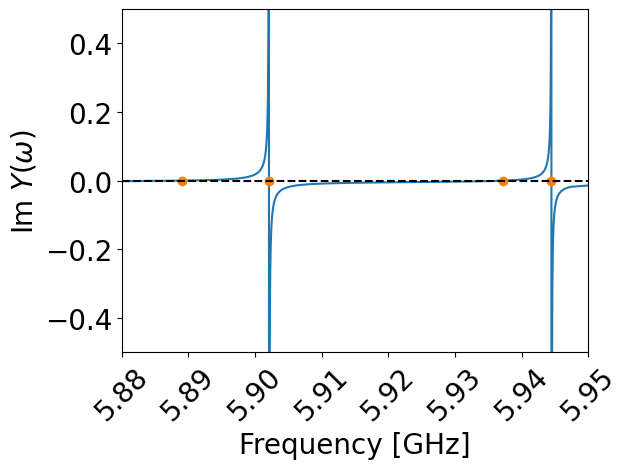

In [102]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata, ydata.imag)
ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
set_xaxis_rot(ax, 45.)
# ax.set_xlim([5.8, 9.1])
ax.set_xlim([5.88, 5.95])
ax.set_ylim([-0.5, 0.5])
ax.axhline(y=0, color='k', ls='--')

fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_15mm_{dstr}.pdf', format='pdf')

## Iterate over all coupler offset values, fix LJ=10 nH

In [103]:
NLJ = 25
wps = []
pcs = []
pls = []
gDs = []
Cps = []
Lps = []
Qps = []
chis = []
Nmodes = 6

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = False
print_results = True

LJs = np.logspace(np.log10(0.1e-9), np.log10(1000e-9), NLJ)
LJs = np.logspace(np.log10(0.1e-9), np.log10(100e-9), NLJ)
# LJs = np.logspace(np.log10(1e-9), np.log10(40e-9), NLJ)
# LJs = np.logspace(np.log10(2.5e-9), np.log10(500e-9), NLJ)
# LJs = np.logspace(np.log10(0.00001e-9), np.log10(0.0001e-9), NLJ)
# LJs = np.logspace(np.log10(0.1), np.log10(100), NLJ)
LJ0 = 10e-9
#for idx, x in enumerate(xdata):
for LJ in LJs:
    wpp, Lp, Cp, Qp, _, _, _, pl, pc, gD, chip \
    = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
    wps.append(np.sort(wpp[0:Nmodes]))
    #wps.append(wpp[0:Nmodes])
    pls.append(pl[0:Nmodes])
    pcs.append(pc[0:Nmodes])
    gDs.append(gD[0:Nmodes, 0:Nmodes])
    Lps.append(Lp[0:Nmodes])
    Cps.append(Cp[0:Nmodes])
    Qps.append(Qp[0:Nmodes])
    chis.append(chip[0:Nmodes, 0:Nmodes])
    if print_results:
        print(f'wps: {wps}')
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
pls  = np.asarray(pls).T
pcs  = np.asarray(pls).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
Qps = np.asarray(Qps).T
chis = np.asarray(chis).T

wp0,_ , _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=None)

wps: [array([3.70836086e+10, 3.70839712e+10, 3.73498336e+10, 3.73501962e+10,
       5.60907844e+10, 5.61003934e+10])]
wps: [array([3.70836086e+10, 3.70839712e+10, 3.73498336e+10, 3.73501962e+10,
       5.60907844e+10, 5.61003934e+10]), array([3.70834273e+10, 3.70839712e+10, 3.73496523e+10, 3.73501962e+10,
       5.60875210e+10, 5.61003934e+10])]
wps: [array([3.70836086e+10, 3.70839712e+10, 3.73498336e+10, 3.73501962e+10,
       5.60907844e+10, 5.61003934e+10]), array([3.70834273e+10, 3.70839712e+10, 3.73496523e+10, 3.73501962e+10,
       5.60875210e+10, 5.61003934e+10]), array([3.70830647e+10, 3.70839712e+10, 3.73494710e+10, 3.73501962e+10,
       5.60831698e+10, 5.61003934e+10])]
wps: [array([3.70836086e+10, 3.70839712e+10, 3.73498336e+10, 3.73501962e+10,
       5.60907844e+10, 5.61003934e+10]), array([3.70834273e+10, 3.70839712e+10, 3.73496523e+10, 3.73501962e+10,
       5.60875210e+10, 5.61003934e+10]), array([3.70830647e+10, 3.70839712e+10, 3.73494710e+10, 3.73501962e+10,
       5.

## Plot the modes of coupled structure

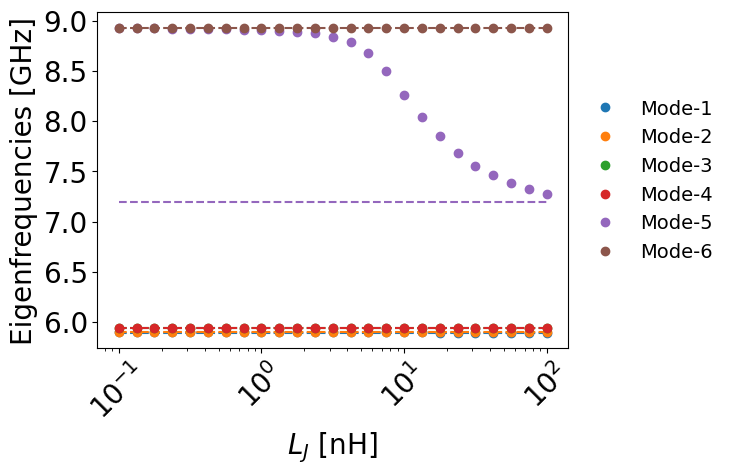

In [104]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([6.158, 6.166])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

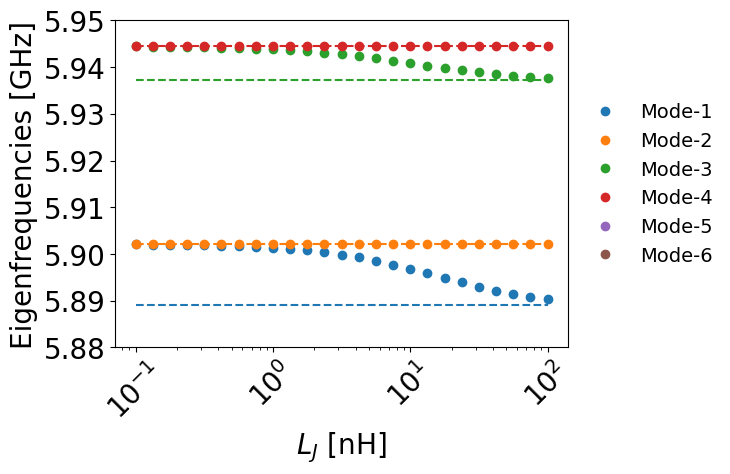

In [105]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
ax.set_ylim([5.88, 5.95])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_zoom_{dstr}.pdf', 
            format='pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
           transparent=True)

In [106]:
wps[0]

array([3.70836086e+10, 3.70834273e+10, 3.70830647e+10, 3.70828834e+10,
       3.70823395e+10, 3.70819769e+10, 3.70812517e+10, 3.70803452e+10,
       3.70790761e+10, 3.70776256e+10, 3.70756313e+10, 3.70730931e+10,
       3.70700110e+10, 3.70662037e+10, 3.70618051e+10, 3.70565874e+10,
       3.70509160e+10, 3.70447910e+10, 3.70386659e+10, 3.70325408e+10,
       3.70266426e+10, 3.70214250e+10, 3.70168423e+10, 3.70130350e+10,
       3.70097716e+10])

## Plot the splittings of the lowest modes vs LJ

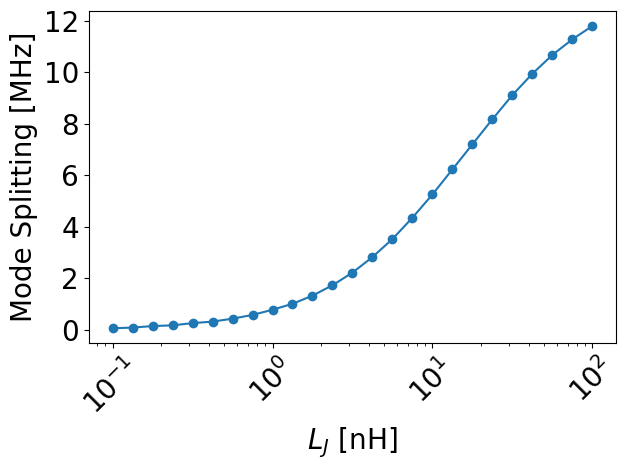

In [107]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ax.plot(LJs/1e-9, (wps[1]-wps[0])/(2*np.pi*fscale2),
           'o-',
            color=cycle[0%clen])
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_ylim([0, 150])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            format='pdf')

In [108]:
(wps[1]-wps[0]) / (2*np.pi*fscale2)

array([ 0.05771 ,  0.086565,  0.144275,  0.17313 ,  0.259695,  0.317405,
        0.432825,  0.5771  ,  0.779085,  1.009925,  1.32733 ,  1.7313  ,
        2.221835,  2.82779 ,  3.52785 ,  4.358265,  5.26089 ,  6.235725,
        7.21056 ,  8.185395,  9.124125,  9.95454 , 10.68389 , 11.289845,
       11.809235])

In [121]:
wps.shape

(6, 25)

## Mode losses

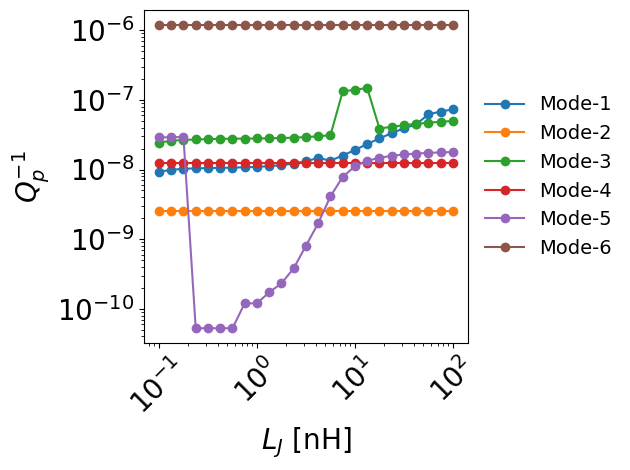

In [109]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps):
    ax.plot(LJs/1e-9, 1./Q,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Q_p^{-1}$', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_losses_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

## Mode $T_1$'s

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps):
    ax.plot(LJs/1e-9, 1e6 * Q / wps[idx],
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.plot(LJs/1e-9, 100*np.ones(LJs.size), 'k--', lw=2)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$T_1$ [$\mu$s]', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_{dstr}.pdf',
            format='pdf')

## Black box results

### $\alpha_p$ and $\chi_{pq}$

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, 0.5 * np.abs(chis[idx, idx, :]) / fscale2,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha_p|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_alpha_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
# Chi, lower triangle
chiT = np.array([np.triu(chis[:,:,i]) for i in range(len(LJs))]).T
gT = np.array([np.triu(gDs[:,:,i]) for i in range(len(LJs))]).T

chiT[0:NM,0:NM,0]

fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 4
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(chiT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(chiT[i, j, :]) / fscale2,
                'o-', label=r'$\chi_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{pq}|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_chi_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 4
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(gT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(gT[i, j, :]) / fscale2,
                'o-', label=r'$g_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|g_{pq}|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_g_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')